# Forward modeling Gravity 

"Forward modeling" is in constrast to "inverse modeling."

### Gravity model 
Gravity can be modeled by assigning density variations to a grid and calculating the gravity response. 
E.g. in 2 dimensions, the grid can be set up to look like the grid below on the right: 

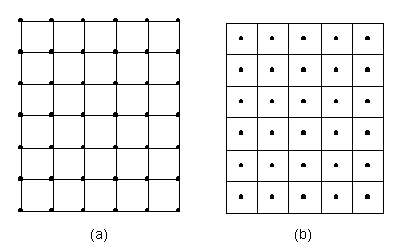

The grid on the left is a "mesh-centered" grid, and on the right is a 'cell-centered' grid. 
We can model gravity using the 'cell-centered' grid by assigning density variations to the cells. 

### Set up some Python functions
We will need some basic Python functions from numpy, and one function `gravity` that will calculate the gravity acceleration anomaly for a density anomaly at a particular point. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
Grav_constant = 6.67408e-11

### Gravity equation
The acceleration due to gravity is given by 
$$ g = G M / r^2 $$
where G is the universal gravitational constant, M is the mass of Earth, and r is the Earth's radius. 

We can apply this to anomalies by assuming a uniform background density structure. 
In this case, we get 
$$ \Delta g = G \Delta M / r^2 $$
where $\Delta M$ is the mass anomaly. 
Then we can use $M = \rho V$ to convert from mass to density: 
$$ \Delta g = G A (\Delta \rho / r^2) $$
where we have switched from 3D to 2D, so A is the area of a cell.
In 3D it would be volume V. 

To solve for density variations, we can isolate the density anomaly from the other terms: 
$$ \Delta g = (G A / r^2) (\Delta \rho ) $$

If we want to get the gravity anomaly in milligals, we can multiply by $10^5$ for our final `gravity` function. 
Note that the `gravity` function is in 2D.  

1 milligal = 10^-3 gal = 0.1 gravity units 

1 gal = 1 cm/sec^2 

In [3]:
# gravity and distance functions in m^2
def gravity(x1, x2, area = 1e6):
    '''Calculate and return all components of the gravity anomaly except the density contrast
    Args: 
      x1: Location of the density anomaly
      x2: Location of the observation point
      area: area of the cells. 
    '''
    r = distance(x1, x2)
    return 1e5*Grav_constant*area/np.square(r)
  
def distance(x1, x2):
  return np.sqrt(np.sum(np.square(x1 - x2)))

### Set up the geometry 
The next step is to set up the grid geometry.
We can do this by defining cell centers at regular intervals. 

In [4]:
# Earth Model Grid 100 point long and 100 points deep. 
# grid nodes 0.5 km apart 
cell_size_x = 20 # meters
cell_size_z = 10 # meters

depth = 200 # meters
length = 600 # meters

xs = np.arange(0, length, cell_size_x)
zs = np.arange(-depth, 0, cell_size_z)
[X, Z] = np.meshgrid(xs,zs)
X_model = np.stack([X.flatten(), Z.flatten()], axis = 1)
print(X_model.shape)

(600, 2)


The geometry will be a regular grid with fixed spacing. 
Much more complicated grids are possible but this simple case will suffice for example.  

Text(0, 0.5, 'Depth')

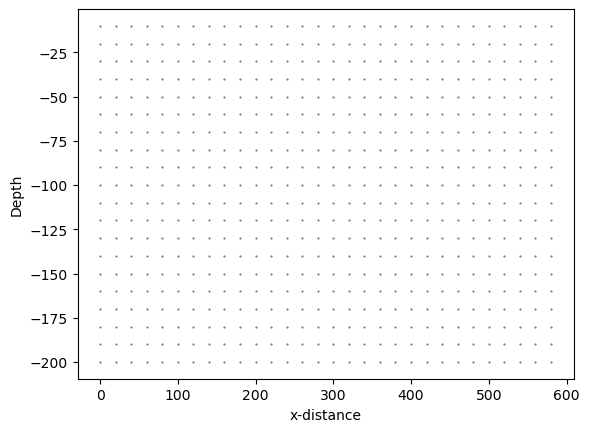

In [8]:
# model
plt.scatter(X.ravel(), Z.ravel(), marker='.', s=1)
plt.xlabel('x-distance')
plt.ylabel('Depth')

In [17]:
#  observation points
x = np.arange(0, 600, 10)
z = np.zeros(x.shape)
X = np.stack([x, z], axis=1)
print(X.shape)

(60, 2)


In [18]:
# Green's Function Matrix
G = np.zeros((len(X), len(X_model)))
for i in range(len(X_model)):
  for j in range(len(X)):
    G[j, i] = gravity(X_model[i, :], X[j, :], area = cell_size_x * cell_size_z)

In [19]:
print(type(G))
print(G.shape)

<class 'numpy.ndarray'>
(60, 600)


In [44]:
# Gravity Model 1
density_anomaly = 3000

model = np.zeros(len(X_model))
model[np.arange(370, 380, 1)] = density_anomaly
model[np.arange(340, 350, 1)] = density_anomaly
model[np.arange(310, 320, 1)] = density_anomaly
model[np.arange(280, 290, 1)] = density_anomaly
model[np.arange(250, 260, 1)] = density_anomaly


In [45]:
model.shape

(600,)

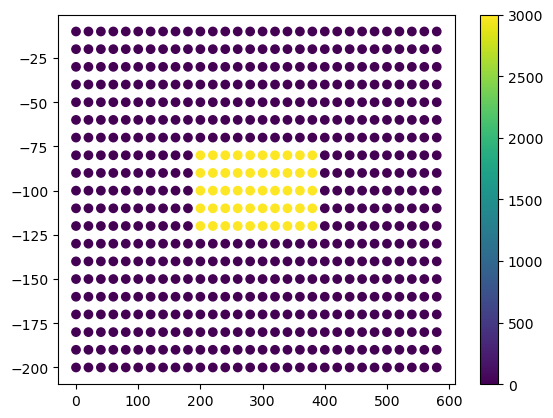

In [46]:
# True Density Anomaly Model
cax = plt.scatter(X_model[:, 0], X_model[:, 1], c=model.ravel())
cbar = plt.colorbar(cax)

In [47]:
d_pred = np.dot(G, model)

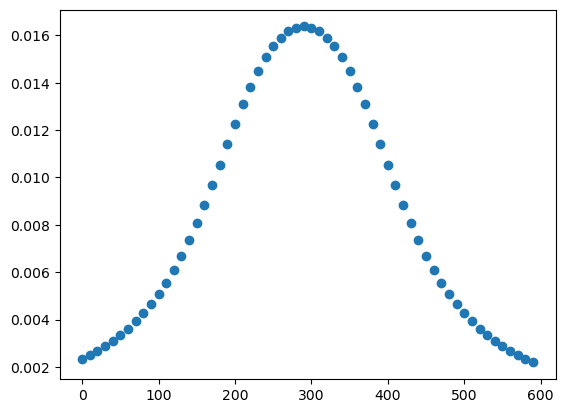

In [48]:
# True Model
plt.plot(x, d_pred, 'o')

In [35]:
# Estimated Model with noise with scale factor equal to 10% of peak true value
d_obs = d_pred + 0.2 * np.nanmax(d_pred.ravel())*np.random.randn(*d_pred.shape)

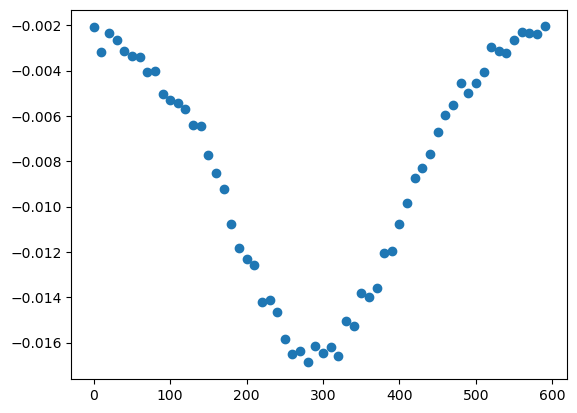

In [36]:
plt.plot(x, d_obs, 'o')

In [ ]:
del d_pred 
del model

**Gravity Model 1:** The data fits the observed data but the estimated model does not match the true model. Because we only have 50 observation points and 400000 model parameters we did not get the exact right solution back. I know that the observed data is accurate because I lowered the parameters to 10000 and saw the location of a large anomaly. This anomaly is dwarved by the shear volume of parameters so it cannot be seen in the true model. The simulated observations show some form of anomaly at the surface. 

In [37]:
# Gravity Model 2
density_anomaly_shallow = -1000
density_updip = 1000

model = np.zeros(len(X_model))
model[np.arange(len(X_model) - 90, len(X_model), 1)] = density_anomaly
model[np.arange(490, 500, 1)] = density_anomaly
model[np.arange(460, 470, 1)] = density_anomaly
model[np.arange(430, 440, 1)] = density_anomaly
model[np.arange(400, 410, 1)] = density_anomaly
model[np.arange(370, 380, 1)] = density_anomaly
model[np.arange(340, 350, 1)] = density_anomaly
model[np.arange(310, 320, 1)] = density_anomaly

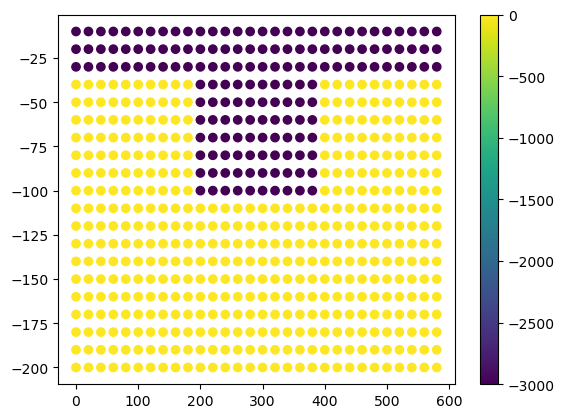

In [39]:
cax = plt.scatter(X_model[:, 0], X_model[:, 1], c=model.ravel())
cbar = plt.colorbar(cax)

In [40]:
d_pred = np.dot(G, model)

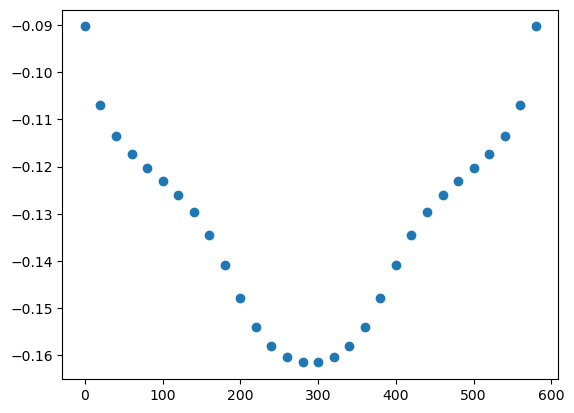

In [41]:
plt.plot(x[::2], d_pred[::2], 'o')

In [42]:
d_obs = d_pred + 0.1 * np.nanmax(d_pred.ravel())*np.random.randn(*d_pred.shape)

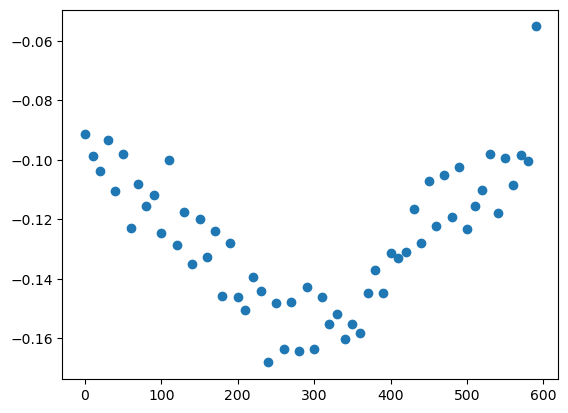

In [43]:
plt.plot(x, d_obs, 'o')

**Part 1: Measuring Gravity using a Smartphone**
  I used the app called Phyphox that had a bunch of sensors, acoustics, and mechanics toolson the iPhone. It had 2 raw sensors for acceleration(linear and gravity). I found gravity acceleration to be 9.84 m/s^2 at lat: 37.954085 and lon: -91.766150. It was 9.82 m/s^2 at lat: 37.953737 and lon: -91.773511
